<a href="https://colab.research.google.com/github/Redzoro1993/Introduction-to-Portfolio-Construction-and-Analysis-with-Python/blob/master/ALM_taller1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np

In [3]:
data = pd.read_excel("Calculo PE Portafolio- Simulación Flujos Contingentes.xlsx", sheet_name = "Portafolio Créditos")
data["n_cuotas_x_pagar"] = data['Plazo (meses)'] - data['Número de cuota actual']
data.head(2)

,Crédito,Plazo (meses),Capital Prestado,Tasa de Interes Efectivo Anual,Número de cuota actual,% Cuotas Pagadas,n_cuotas_x_pagar
0,1,24,90,0.2,14,0.4,10
1,2,24,30,0.2,13,0.3,11


In [5]:
creditos1 = []
for i in range(data.shape[0]):
    n_cuotas_x_pagar = data['n_cuotas_x_pagar'].iloc[i]
    
    capital = data['Capital Prestado'].iloc[i]
    tasa_ea = data['Tasa de Interes Efectivo Anual'].iloc[i]
    tasa_mensual = (tasa_ea + 1) ** (1/12) - 1
    
    capital_amort = [capital - j*capital/data['Plazo (meses)'].iloc[i]  for j in range(data['Plazo (meses)'].iloc[i])]
    capital_amort = capital_amort[data['Número de cuota actual'].iloc[i]:]
    flujos = [ capital/data['Plazo (meses)'].iloc[i] + c*tasa_mensual  for c in   capital_amort ]
    creditos1.append([i,flujos])
    
n_credito = 0 # el credito Numero 1 
print("El credito numero " + str(n_credito+1) + " tiene los flujos: ")
print(creditos1[n_credito][1])
print("El credito numero " + str(n_credito+1) + " le hacen falta pagar " +str(len(creditos1[n_credito][1])) + " flujos.")


El credito numero 1 tiene los flujos: 
[4.32410514373992, 4.266694629365928, 4.209284114991936, 4.151873600617944, 4.094463086243952, 4.0370525718699595, 3.979642057495968, 3.922231543121976, 3.864821028747984, 3.807410514373992]
El credito numero 1 le hacen falta pagar 10 flujos.


In [24]:
creditos = pd.DataFrame(creditos1)

In [25]:
creditos

,0,1
0,0,"[4.32410514373992, 4.266694629365928, 4.209284..."
1,1,"[1.460505219371304, 1.4413683812466398, 1.4222..."
2,2,"[3.363192889575493, 3.3185402672846105, 3.2738..."
3,3,"[4.711185678309141, 4.660154109976704, 4.60912..."
4,4,"[2.324285358887097, 2.2902643133321385, 2.2562..."
...,...,...
245,245,"[2.3555928391545704, 2.330077054988352, 2.3045..."
246,246,"[0.8843649016657706, 0.8716070095826614, 0.858..."
247,247,"[1.6724583627679215, 1.6554478399904424, 1.638..."
248,248,"[1.2288279879097224, 1.216070095826613, 1.2033..."


In [7]:
# Punto 2
tabla_prob_no_pago =  pd.read_excel("Calculo PE Portafolio- Simulación Flujos Contingentes.xlsx", sheet_name = "Tablas Probabilidad No-Pago")
names = tabla_prob_no_pago.columns.tolist() 
names[0] = 'edad'
tabla_prob_no_pago.columns = names
names

# Si el % de cuotas no pagadas es  menor al 60% entonces voy a buscar la probabilidad de default asociada a <50%
data.loc[data['% Cuotas Pagadas'] < 0.6,'% Cuotas Pagadas'] = names[-1]

In [8]:
def simulando_credito_i(i,tabla_prob_no_pago,sim):
    simulaciones = []
    while len(simulaciones) < sim: # obligar tener 1000 simulaciones
        # probabilidad de no pago inicial:
            # Si el % de cuotas no Pagados es inferior al 50% entonces toma una probabilidad de default mas alto de la edad del credito
        caminata_j = []
        contador = 0 # numero de veces que hace default dentro de la simulacion j
        porc_cuotas_pagadas = data['% Cuotas Pagadas'].iloc[i] # score de pago
        for flujo in range(data['Número de cuota actual'].iloc[i]+1,data['Plazo (meses)'].iloc[i]+1): # cada caminata tiene diferentes flujos
            edad_credito_i = (flujo) / data['Plazo (meses)'].iloc[i]
            edad_credito_i = round(edad_credito_i,1)
            if edad_credito_i  < 1:
                prob_no_pago = float(tabla_prob_no_pago[tabla_prob_no_pago["edad"] == edad_credito_i][porc_cuotas_pagadas])
                evento_pago = float(np.random.binomial(1,1-prob_no_pago,1))
                #prob_no_pago = float(tabla_prob_no_pago[tabla_prob_no_pago["edad"] == edad_credito_i][porc_cuotas_pagadas])
                # si toma valor de 1 significa que realizo el pago | prob = 0 realizo el default
                #prob_simulada = np.matrix([np.random.binomial(1,1-prob_no_pago,1) for j in range(data["n_cuotas_x_pagar"].iloc[i]) ])
                if evento_pago  == 0 and porc_cuotas_pagadas == "<50%" or evento_pago  == 1: 
                    # Hizo default y esta en el peor score de credito
                    # O se mantiene en el mismo score de credito         
                    # en cualquier caso, no se actualiza el porcentaje de cuotas pagadas              
                    pass    
                    
                elif evento_pago  == 0: # hizo default y se detiera la cartera
                    contador = contador + 1 # hizo default    
                    porc_cuotas_pagadas = (flujo - contador) / flujo # % de cuotas pagados actualizando el evento de default
                    porc_cuotas_pagadas = round(porc_cuotas_pagadas,1)
                    if porc_cuotas_pagadas <= 0.5:
                     porc_cuotas_pagadas ='<50%'
            else: # estoy en el ultimo flujo
                edad_credito_i = 0.9
                prob_no_pago = float(tabla_prob_no_pago[tabla_prob_no_pago["edad"] == edad_credito_i][porc_cuotas_pagadas])
                evento_pago = float(np.random.binomial(1,1-prob_no_pago,1))
                edad_credito_i = round(edad_credito_i,1)
            caminata_j.append([flujo,evento_pago,edad_credito_i,porc_cuotas_pagadas,prob_no_pago])
                
        
        #guardo las simulaciones
        
        simulaciones.append(caminata_j)
        #simu.append(camin_j)
    return(simulaciones)

sim = 1000
simulaciones = simulando_credito_i(i,tabla_prob_no_pago,sim)
print("Simulacion 1: ")
simulaciones[0]
print("Simulacion 2: ")
simulaciones[1]
print("Simulacion 3: ")
simulaciones[2]

Simulacion 1: 
Simulacion 2: 
Simulacion 3: 


[[12, 1.0, 0.5, 1.0, 0.06000000000000005],
 [13, 1.0, 0.5, 1.0, 0.06000000000000005],
 [14, 1.0, 0.6, 1.0, 0.06999999999999995],
 [15, 1.0, 0.6, 1.0, 0.06999999999999995],
 [16, 1.0, 0.7, 1.0, 0.07999999999999996],
 [17, 1.0, 0.7, 1.0, 0.07999999999999996],
 [18, 1.0, 0.8, 1.0, 0.08999999999999997],
 [19, 1.0, 0.8, 1.0, 0.08999999999999997],
 [20, 1.0, 0.8, 1.0, 0.08999999999999997],
 [21, 1.0, 0.9, 1.0, 0.09999999999999998],
 [22, 1.0, 0.9, 1.0, 0.09999999999999998],
 [23, 1.0, 0.9, 1.0, 0.09999999999999998],
 [24, 1.0, 0.9, 1.0, 0.09999999999999998]]

Loading...: 100%|██████████| 250/250 [54:32<00:00, 12.47s/it]

La simulacion N. 1 del credito 1 es:


Loading...: 100%|██████████| 250/250 [06:18<00:00,  1.50s/it]


El credito N. 5 tiene 3 flujos y 1000 simulaciones


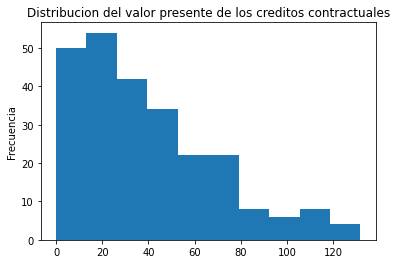

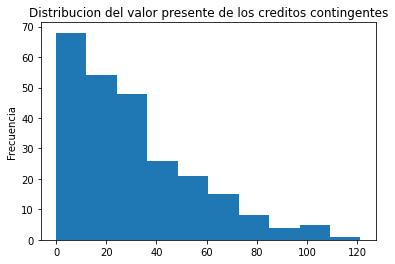

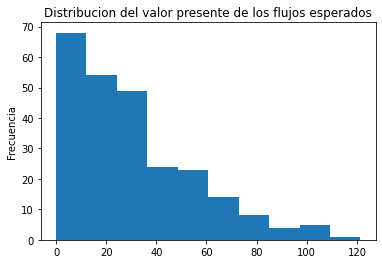

KeyError: ignored

<Figure size 720x504 with 0 Axes>

In [9]:
## realizando la simulacion para todos los 259 papeles:

from tqdm import tqdm 
loop = tqdm(total =data.shape[0], position = 0, leave =  False)

all_sim_creditos = []
for i in range(data.shape[0]):
    simulaciones = simulando_credito_i(i,tabla_prob_no_pago,sim)
    all_sim_creditos.append(simulaciones)
    loop.set_description("Loading...".format(i))
    loop.update(1)

## simulacion de cuotas futuras contigentes:

n_credito = 0 #numero del credito
creditos1[n_credito][0] # numero del credito
creditos1[n_credito][1] # flujos del credito

n_sim = 0 # simulacion 1
print("La simulacion N. " + str(n_sim+1) + " del credito " + str(n_credito+1) + " es:")
all_sim_creditos[n_credito][n_sim]

cuotas_x_evento = [] # flujo_n * evento_sim_n , me quedo con los flujos que me pagan
cuotas_esperadas = [] #flujo_n * (1-prob_no_pago) 
loop = tqdm(total =data.shape[0], position = 0, leave =  False)
for n_credito in range(data.shape[0]):
    cuotas_x_evento_i = []
    cuotas_esperadas_i = []
    for n_sim in range(sim):
        if len(creditos1[n_credito][1]) == 0:# el credito numero 23 falla porque esta en la cuota 24 y tiene 24 cuotas
            cuotas_x_evento_i.append(np.array(0))
            cuotas_esperadas_i.append(np.array(0))
        else:
            cuotas_x_evento_i.append(np.multiply(creditos1[n_credito][1],pd.DataFrame(all_sim_creditos[n_credito][n_sim])[1].tolist()))
            cuotas_esperadas_i.append(np.multiply(creditos1[n_credito][1],(1-pd.DataFrame(all_sim_creditos[n_credito][n_sim])[4]).tolist()))
    cuotas_x_evento.append(cuotas_x_evento_i)
    cuotas_esperadas.append(cuotas_esperadas_i)
    loop.set_description("Loading...".format(n_credito))
    loop.update(1)

n_credito = 0
n_sim = 0
cuotas_x_evento[n_credito][n_sim]
cuotas_esperadas[n_credito][n_sim]

n_credito = 4
print()
print("El credito N. "+str(n_credito+1) + " tiene " +str(np.matrix(cuotas_x_evento[n_credito]).shape[1]) + " flujos y " + str(np.matrix(cuotas_x_evento[n_credito]).shape[0]) + " simulaciones")

# simulacion de montecarlo sobre los flujos hallados
sim_cuotas_x_evento = []
sim_cuotas_esperadas = []
for n_credito in range(data.shape[0]):
    sim_cuotas_x_evento.append(np.array(cuotas_x_evento[n_credito]).mean(axis=0))
    sim_cuotas_esperadas.append(np.array(np.array(cuotas_esperadas[n_credito]).mean(axis=0)))  

len(sim_cuotas_esperadas )
len(sim_cuotas_x_evento )

## Valor Presente de las cuotas futuras contractuales de los creditos:
tir_ea = 0.1
tir_mensual = (1+tir_ea) ** (1/12) -1

vp = []
for n_credito in range(data.shape[0]):
    vp_i = [creditos1[n_credito][1][i] /(1+tir_mensual)**(i)  for i in range(len(creditos1[n_credito][1]))]
    vp.append([vp_i,np.sum(vp_i)])

## Valor Presente de las cuotas futuras contigentes de los creditos:
vp_cuotas_x_evento = []
vp_cuotas_esperadas = []
for n_credito in range(data.shape[0]):
    if sim_cuotas_esperadas[n_credito].shape == ():
        vp_cuotas_x_evento.append(np.array(sim_cuotas_x_evento[n_credito] / (1+tir_mensual)**i))
        vp_cuotas_esperadas.append(np.array(sim_cuotas_esperadas[n_credito] / (1+tir_mensual)**i))
    else:
        vp_cuotas_x_evento.append( [sim_cuotas_x_evento[n_credito][i] / (1+tir_mensual)**i for i in range(len(sim_cuotas_x_evento[n_credito]))])
        vp_cuotas_esperadas.append( [sim_cuotas_esperadas[n_credito][i] / (1+tir_mensual)**i for i in range(len(sim_cuotas_esperadas[n_credito]))])

len(vp_cuotas_x_evento)
len(vp_cuotas_esperadas)


# evento comparativo
sum_vp_contractual = []
sum_vp_contigentes_x_evento = []
sum_vp_contigentes_esperadas = []
for n_credito in range(data.shape[0]):
    sum_vp_contractual.append(vp[n_credito][1])
    sum_vp_contigentes_x_evento.append(np.sum(vp_cuotas_x_evento[n_credito]))
    sum_vp_contigentes_esperadas.append(np.sum(vp_cuotas_esperadas[n_credito]))
    
import matplotlib.pyplot as plt
plt.hist(sum_vp_contractual)    
plt.title("Distribucion del valor presente de los creditos contractuales")
plt.ylabel("Frecuencia")
plt.show()

plt.hist(sum_vp_contigentes_x_evento)
plt.title("Distribucion del valor presente de los creditos contingentes")
plt.ylabel("Frecuencia")
plt.show()

plt.hist(sum_vp_contigentes_esperadas)
plt.title("Distribucion del valor presente de los flujos esperados")
plt.ylabel("Frecuencia")
plt.show()

####################
data["sum_vp_contractual"] =np.array(sum_vp_contractual)
data["sum_vp_contigentes_x_evento"] =np.array(sum_vp_contigentes_x_evento)
data["sum_vp_contigentes_esperadas"] =np.array(sum_vp_contigentes_esperadas)

# Gráfico de dispersión:
fig = plt.figure(figsize=(10,7))
plt.scatter(x=np.matrix(data)[:,-1] , y=data["sum_vp_contractual"], c = data['% de cuotas Pagados'], cmap='rainbow')
plt.xlabel('sum_vp_contigentes_esperadas')
plt.ylabel('sum_vp_contractual')
plt.title('Gráfico de Dispersión de los Componentes Principales')
plt.show()

np.matrix(data)[:,-1]
data.columns


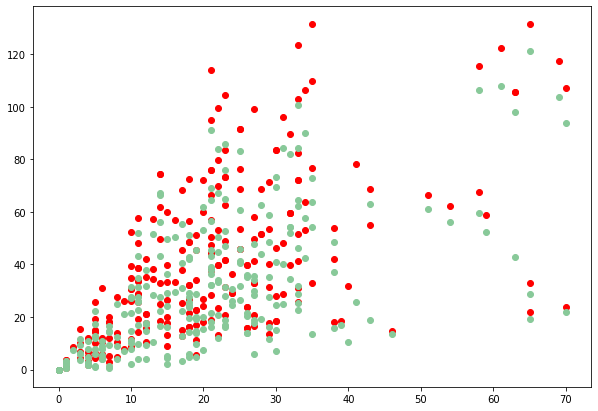

In [38]:
# Gráfico de dispersión:
fig = plt.figure(figsize=(10,7))
plt.scatter(x = data["n_cuotas_x_pagar"] , y=data["sum_vp_contractual"], color='Red')
# plt.xlabel('sum_vp_contigentes_esperadas')
# plt.ylabel('sum_vp_contractual')
# plt.title('Gráfico de Dispersión de titulos')
# plt.show()

plt.scatter(x=data["n_cuotas_x_pagar"] , y=data["sum_vp_contigentes_x_evento"], color = '#88c999')
# plt.show()

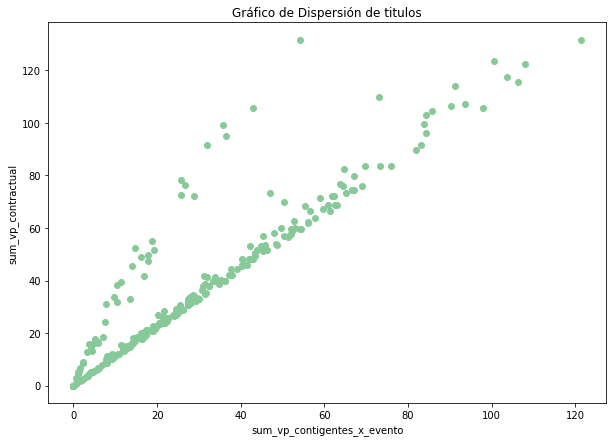

In [14]:
fig = plt.figure(figsize=(10,7))
plt.scatter(x=data["sum_vp_contigentes_x_evento"] , y=data["sum_vp_contractual"], color = '#88c999')
plt.xlabel('sum_vp_contigentes_x_evento')
plt.ylabel('sum_vp_contractual')
plt.title('Gráfico de Dispersión de titulos')
plt.show()

In [26]:
data["PE_Portafolio"] = data["sum_vp_contractual"] - data["sum_vp_contigentes_x_evento"]

In [29]:
print("la perdida esperada del portaflio es : " + str(data["PE_Portafolio"].sum()))

la perdida esperada del portaflio es : 2181.336697002698


In [30]:
data

,Crédito,Plazo (meses),Capital Prestado,Tasa de Interes Efectivo Anual,Número de cuota actual,% Cuotas Pagadas,n_cuotas_x_pagar,sum_vp_contractual,sum_vp_contigentes_x_evento,sum_vp_contigentes_esperadas,PE_Portafolio
0,1,24,90,0.2,14,<50%,10,39.276598,11.385699,11.091364,27.890899
1,2,24,30,0.2,13,<50%,11,14.449131,4.131827,4.193655,10.317304
2,3,24,70,0.2,14,1,10,30.548465,27.462613,27.460442,3.085852
3,4,36,120,0.2,9,<50%,27,99.356676,35.733406,35.741242,63.623271
4,5,36,80,0.2,33,0.9,3,6.817117,5.912556,5.887162,0.904561
...,...,...,...,...,...,...,...,...,...,...,...
245,246,36,60,0.2,9,<50%,27,49.678338,17.887719,17.870621,31.790619
246,247,36,30,0.2,32,0.9,4,3.420560,2.960336,2.962280,0.460224
247,248,36,40,0.2,3,0.7,33,41.168146,31.953316,32.037293,9.214829
248,249,36,30,0.2,5,0.9,31,28.844579,25.044206,25.147956,3.800372
